# Лабораторна робота 10, 11

У темі 7 *Контрольоване виявлення аномалій* ми дізналися, що за наявності навчальних даних можна використовувати контрольоване виявлення аномалій, яке перетворює проблему виявлення аномалії на проблему класифікації, хоча й з особливими проблемами. У лекції ми зосередилися на одній загальній проблемі: класовий дисбаланс, який виникає через рідкість аномалій (за визначенням).

Тут виявлятимуть аномалії в змодельованих наборах даних за допомогою методів економічного навчання, адаптивної повторної вибірки та посилення.


# Результати навчання

Ви повинні мати:

1. розуміння контрольованого виявлення аномалій
2. деякий практичний досвід економічного навчання, адаптивної повторної вибірки та методів посилення.



# Імпорт

Цей файл використовує два пакети, які можуть потребувати інсталяції:

1. Mlxtend (розширення машинного навчання), що є бібліотекою Python корисних інструментів для завдань науки про дані.
(http://rasbt.github.io/mlxtend/)


2. imbalance-learn, який є пакетом Python, який пропонує методи повторної дискретизації, які зазвичай використовуються в наборах даних, які демонструють сильний дисбаланс класів
(https://imbalanced-learn.org/stable/install.html#getting-started)

Інструкція зі встановлення наведена нижче.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from collections import Counter
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# Розділ 1: Економічне навчання

У цьому розділі ми збираємося використовувати змодельовані дані, щоб дослідити економічне навчання. Наше контрольоване виявлення аномалій здійснюватиметься за допомогою класифікатора дерева рішень (https://scikit-learn.org/stable/modules/tree.html#tree).

Ми будемо діяти наступним чином:

1. Створіть змодельовані дані
2. Навчіть наш алгоритм, надаючи всім точкам даних однакову вагу
3. Вивчіть неправильні класифікації за допомогою матриці помилок
4. Повторіть кроки (2) і (3), використовуючи економічне навчання, і порівняйте наші результати.

### Data

Ми створюємо синтетичні дані за допомогою функції *make_classification* sklean. Ми створюємо 5000 точок із приблизно 90% нормальних точок (мітка 0) і 10% аномалій (мітка 1).

In [2]:
# Generate synthetic imbalanced data 
features, label = make_classification(n_samples=5000, n_features=2, 
                                      n_informative=2, n_redundant=0, 
                                      n_repeated=0, n_classes=2, 
                                      n_clusters_per_class=1,
                                      weights=[0.90, 0.10], flip_y=0.01,
                                      class_sep=1.5, random_state=42)


Для детального пояснення параметрів *make_classification* перегляньте https://scikitlearn.org/stable/modules/generated/sklearn.datasets.make_classification.html.

Тут ми обговоримо деякі з них.

Ми вказуємо початкові ваги нормального та аномального класу 0,90 та 0,10 відповідно, використовуючи *weights*.

За допомогою *flip_y* ми вказуємо частку точок, класи яких випадково обмінюються, щоб внести певний шум у дані.

І ми використовуємо *class_sep*, щоб визначити поділ між двома класами; більші значення розподіляються по класах.

In [3]:
df = pd.DataFrame(features, columns=['feature1', 'feature2'])
df['label'] = label

Побудуйте графік даних, позначивши кольорами нормальні і аномальні точки. Тут ми використовуємо *lmplot* від *seaborn*, оскільки він пропонує компактний спосіб позначати точки за класом.

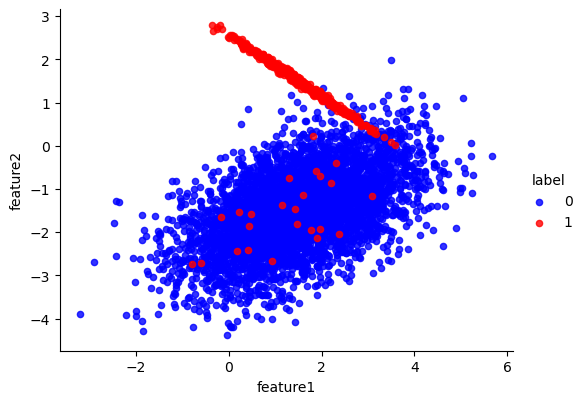

In [4]:
colors = ['blue', 'red']
sns.lmplot('feature1', 'feature2', data=df, hue='label',
           palette=colors, fit_reg=False, scatter_kws={'s': 20})
plt.gcf().set_size_inches(6,4);

Тепер ми навчаємо нашого класифікатора. Ми будемо використовувати дерево рішень з єдиним розбиттям. Це дерево приймає рішення на основі однієї вхідної функції.

In [5]:
# Звичайне дерево
tree_plain = DecisionTreeClassifier(max_depth=1, class_weight=None)

Ми будемо використовувати *plot_decision_regions* з *mlxtend*, щоб показати регіони, які використовує classfier для призначення міток класу.

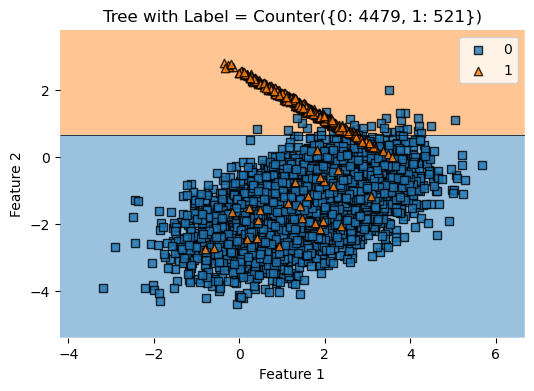

In [6]:
tree_plain_fit = tree_plain.fit(features, label)
plot_decision_regions(features, label, tree_plain_fit)
plt.title(f'Tree with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Як і очікувалося, два класи розділені однією лінією, оскільки для поділу використовувалася лише одна функція.

Далі ми розглянули статистику класифікації.

In [7]:
cm_tree_plain=confusion_matrix(label, tree_plain.predict(features))
print(cm_tree_plain)
accuracy_tree_plain = accuracy_score(label, tree_plain.predict(features))
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


Ми неправильно класифікували 37 нормальних точок і 47 аномалій. Непогано, але давайте спробуємо покращити цей результат.

Для цього ми запровадимо економічне навчання. Для нашого дерева рішень економічне навчання можна запровадити за допомогою параметра *class_weight*. У попередньому аналізі для цього параметра було встановлено значення *None*, що означає, що всі точки мали однакову вагу.

У нашій наступній ітерації ми встановимо *class_weight* на *balanced*. У цьому випадку ваги встановлюються обернено пропорційно частоті класу. Тобто ціна помилки обернено пропорційна кількості екземплярів цього класу, приклад якого ми обговорювали в лекції.

Щоб отримати докладніші відомості, див.

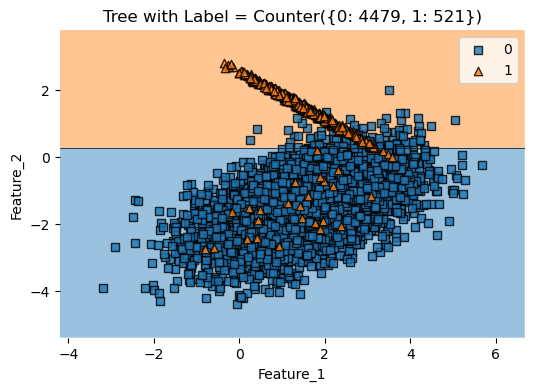

In [8]:
tree_bal = DecisionTreeClassifier(max_depth=1, class_weight='balanced') # balanced - збалансовані вхідні дані
tree_bal_fit = tree_bal.fit(features, label)
plot_decision_regions(features, label, tree_bal_fit)
plt.title(f'Tree with Label = {Counter(label)}')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Зверніть увагу, що межа перемістилася. Тепер воно ближче до Feature_2 = 0. Це багатообіцяюче. Це показує, що економічне навчання вплинуло на класифікацію. Це на краще?

In [9]:
cm_tree_bal=confusion_matrix(label, tree_bal.predict(features))
print(cm_tree_bal)
accuracy_tree_bal = accuracy_score(label, tree_bal.predict(features))
print(f'Accuracy: {accuracy_tree_bal}')

[[4381   98]
 [  27  494]]
Accuracy: 0.975


Точність впала, і ми неправильно класифікували більше нормальних точок (98 проти 37 раніше).

Однак ми вдосконалили нашу класифікацію аномалій. Лише 27 були неправильно класифіковані (проти 47 раніше). Якщо для нас найбільше значення мають аномалії, нижчий рівень неправильної класифікації є значним покращенням.

Економічне навчання робить те, для чого воно призначене: допомагає виявляти аномалії.

# Розділ 2: Адаптивна повторна вибірка

У цьому розділі ми збираємося використовувати дані з попереднього розділу, щоб проілюструвати адаптивну повторну вибірку. Наше контрольоване виявлення аномалій здійснюватиметься за допомогою класифікації опорних векторів — SVC (https://scikit-learn.org/stable/modules/svm.html#svm-classification).


Ми будемо продовжувати, як і раніше:

1. Навчіть наш алгоритм виявлення аномалій без повторної вибірки
2. Обчисліть вартість нашої неправильної класифікації
3. Повторіть кроки (2) і (3), використовуючи адаптивну повторну вибірку, і порівняйте наші результати.

Спочатку ми створюємо наш класифікатор, використовуючи навчальний набір даних.

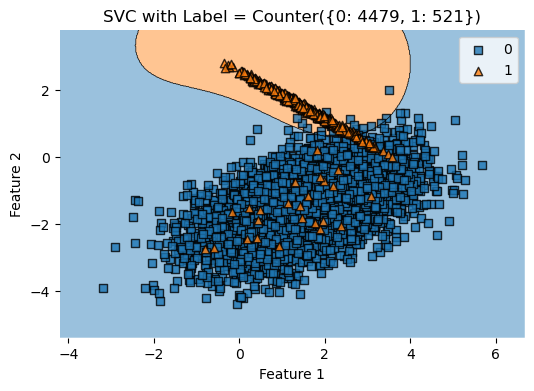

In [10]:
clf = SVC().fit(features, label)
plot_decision_regions(features, label, clf)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

Ми бачимо (з назви рисунка), що маємо 521 аномалію і 4479 нормальних точок. Тобто 10,4% точок – це аномалії.

Давайте подивимося на матрицю помилок, щоб побачити, наскільки добре працює наш класифікатор.

In [11]:
cm=confusion_matrix(label, clf.predict(features))
print(cm)

[[4457   22]
 [  47  474]]


Щоб було зрозуміліше, ми роздруковуємо кожну категорію.

In [12]:
tn, fp, fn, tp = cm.ravel()
print(f'True Negative: {tn}')   #роздрукуємо кожну категорію міток з матриці помилок/ нормальні правильно спрогнозовані
print(f'False Positive: {fp}')#нормальні помилково спрогнозовані
print(f'False Negative: {fn}')#аномалії помилково спрогнозовані
print(f'True Positive: {tp}') #аномалії правильно спрогнозовані
accuracy = accuracy_score(label, clf.predict(features))
print(f'Accuracy: {accuracy}')

True Negative: 4457
False Positive: 22
False Negative: 47
True Positive: 474
Accuracy: 0.9862


Іншими словами, ми неправильно класифікували 22 нормальні точки та 47 аномалій. Чи можемо ми зробити краще?

### Oversampling

Як першу спробу покращити, давайте виберемо клас аномалії. Ми використаємо *RandomOverSampler* від *imblearn*, щоб створити набір тренувальних даних із повторною вибіркою.

Основні дані: наскільки ми хочемо збільшити вибірку класу аномалії. Тут ми вкажемо надвибірку як частку розміру нормального класу. Ця частка, *resample_ratio*, має відповідати двом умовам:

1. Воно повинно бути менше або дорівнювати 1, щоб клас аномалії завжди залишався меншим.

2. Частка має бути достатньо великою, ніж кількість точок аномалії в наборі даних із повторною надвибіркою перевищує кількість у вихідному наборі даних. В іншому випадку ми будемо занижувати вибірку класу аномалії.

Порушення будь-якої умови створює попередження. 

In [13]:
# Random oversampling of the anomaly class
resample_ratio = 0.3 # (anomalies / normal) after resampling
sample_normal = tn + fp # total number of true normal points
sample_anomaly = int(resample_ratio*sample_normal) # must be an integer
sampling_dict = {0: sample_normal, 1: sample_anomaly}
ros = RandomOverSampler(sampling_strategy=sampling_dict, random_state=0) 
features_resampled, label_resampled = ros.fit_resample(features,label)

Покажіть, скільки точок у кожному класі після повторної вибірки

In [14]:
Counter(label_resampled)

Counter({0: 4479, 1: 1343})

In [15]:
Counter(label)

Counter({0: 4479, 1: 521})

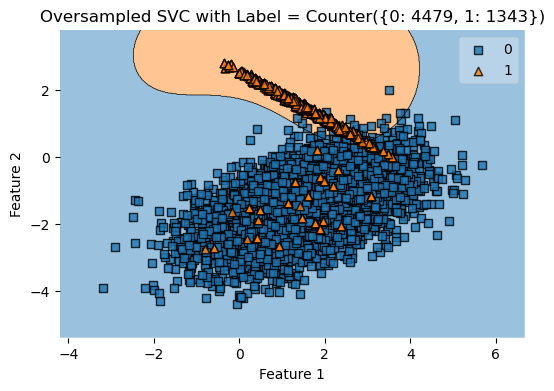

In [16]:
clf_ros = SVC().fit(features_resampled, label_resampled)
plot_decision_regions(features_resampled, label_resampled, clf_ros)
plt.title(f'Oversampled SVC with Label = {Counter(label_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(6,4)

Як і раніше, ми показуємо матрицю помилок та окремі категорії для наших прогнозів.

In [17]:
cm_ros = confusion_matrix(label, clf_ros.predict(features))
cm_ros

array([[4443,   36],
       [  35,  486]], dtype=int64)

In [18]:
tn_ros, fp_ros, fn_ros, tp_ros = cm_ros.ravel()
print('After Random Oversampling')
print(f'True Negative: {tn_ros}')
print(f'False Positive: {fp_ros}')
print(f'False Negative: {fn_ros}')
print(f'True Positive: {tp_ros}')
accuracy_ros = accuracy_score(label, clf_ros.predict(features))
print(f'Accuracy: {accuracy_ros}')

After Random Oversampling
True Negative: 4443
False Positive: 36
False Negative: 35
True Positive: 486
Accuracy: 0.9858


Зараз ми неправильно класифікували 36 нормальних точок і 35 аномалій.

Раніше ми неправильно класифікували 47 нормальних точок і 22 аномалії.

Що краще?

Відповідь залежить від вартості неправильної класифікації.

Визначимо функцію, яка обчислює цю вартість. У наведеній нижче функції ми неявно припускаємо, що правильно класифікована точка не має вартості.

In [19]:
def misclass_cost(false_pos, false_neg, false_pos_cost, false_neg_cost):
    '''
    Calculates the cost of misclassified instances
   
    Args: 
        false_pos: number of false positives (float)
        false_neg: number of false negatives (float)
        false_pos_cost: cost of a false positive (float > 0)
        false_neg_cost: cost of a false negative (float > 0)
        
    Returns: 
        misclass_cost: the cost of misclassifcation (float)
        
    Raises:
        Error: if false_pos_cost or false_neg_cost are non-positive
    '''
    if(false_pos_cost <= 0  or false_neg_cost <= 0):
        print('Costs must be greater than zero')
        return
    else:
        misclass_cost = (false_pos*false_pos_cost 
                         + false_neg*false_neg_cost)
        return misclass_cost

Тепер призначити витрати. Ми будемо дотримуватися підходу, описаного в лекції для скринінгового тесту, де вартість хибнонегативного результату вища, ніж хибнопозитивного.

In [20]:
false_pos_cost = 10  #для класу нормальних коеф. вартості: с=1/5000
false_neg_cost = 100 #для класу аномалій коеф. вартості: с=1/521 (в 10 разів більше)

Нарешті, ми можемо розрахувати вартість на основі звичайного набору даних і даних із випадковою надмірною вибіркою.

In [21]:
cost_reg = misclass_cost(fp, fn, false_pos_cost, false_neg_cost)
cost_ros = misclass_cost(fp_ros, fn_ros, false_pos_cost, false_neg_cost)
print(f'Without oversampling the cost is: {cost_reg}')
print(f'With random oversampling the cost is: {cost_ros}')
print('')
print(f'Accuracy without oversampling is: {accuracy}')
print(f'Accuracy with random oversampling is: {accuracy_ros}')

Without oversampling the cost is: 4920
With random oversampling the cost is: 3860

Accuracy without oversampling is: 0.9862
Accuracy with random oversampling is: 0.9858


Випадкова надмірна вибірка знизила вартість неправильної класифікації, незважаючи на меншу точність.

**Питання**: що станеться, якщо витрати на хибно-позитивний і хибно-негативний результат рівні?

**Відповідь**: вартість буде пропорційна (1-точність). Іншими словами, використання точності як метрики еквівалентно припущенню рівних витрат для двох категорій.

### Undersampling

Давайте подивимося, як працює недостатня вибірка. Структура цього розділу така ж, як і для надвибірки, за винятком того, що тепер ми виконуємо недобірку звичайного класу.

Як і раніше, у нас є важливий вхід: наскільки ми хочемо зменшити вибірку звичайного класу. Тут ми вкажемо недостатню вибірку як кратне розміру класу аномалії. Цей множник, *resample_ratio_under*, має відповідати двом умовам:

1. Воно повинно бути більше або дорівнювати 1, щоб нормальний клас завжди залишався більшістю.

2. Множник має бути достатньо малим, ніж кількість нормальних точок у наборі даних із повторною надвибіркою менша за кількість у вихідному наборі даних. В іншому випадку ми матимемо надмірну вибірку звичайного класу.

In [22]:
# Випадкова недовибірка нормального класу

# resample_ratio_under — це (норма/аномалії) після повторної вибірки
# Має бути int, але int() додано пізніше, щоб запобігти помилці
resample_ratio_under = 1 # a 1:1 ratio is a typical starting point / типове початкове значення відношення

sample_anomaly_under = tp + fn 

# загальна кількість справжніх нормальних точок
# int є захистом у випадку, якщо resample_ratio_under задано як float
sample_normal_under = int(resample_ratio_under*sample_anomaly_under)

sampling_dict = {0: sample_normal_under, 1: sample_anomaly_under}
rus = RandomUnderSampler(sampling_strategy=sampling_dict, random_state=0) 
features_resampled_2, label_resampled_2 = rus.fit_resample(features,label)

In [23]:
# Перевірити недостатню вибірку
Counter(label_resampled_2)

Counter({0: 521, 1: 521})

Для простоти опустіть графік і просто обчисліть статистику

In [24]:
clf_rus = SVC().fit(features_resampled_2, label_resampled_2)

In [25]:
cm_rus = confusion_matrix(label, clf_rus.predict(features))
print(cm_rus)
accuracy_rus = accuracy_score(label, clf_rus.predict(features))
tn_rus, fp_rus, fn_rus, tp_rus = cm_rus.ravel()
cost_rus = misclass_cost(fp_rus, fn_rus, false_pos_cost, false_neg_cost)
print('')
print(f'With random undersampling the cost is: {cost_rus}')
print(f'Accuracy with random undersampling is: {accuracy_rus}')

[[4388   91]
 [  27  494]]

With random undersampling the cost is: 3610
Accuracy with random undersampling is: 0.9764


Недостатня вибірка навіть краща, ніж надмірна вибірка з точки зору вартості, незважаючи на подальше зниження точності.

# Розділ 3: AdaBoost


У цьому розділі ми розглянемо методи посилення. Точніше, ми розглянемо адаптивне посилення (AdaBoost).

Як ми обговорювали в лекції, AdaBoost добре працює з будь-яким слабким учнем, але найчастіше він використовується з деревами рішень. Тому в цьому розділі ми застосуємо його до звичайного дерева з розділу 1 (де *class_weight* має значення *None*) і перевіримо, чи покращить це наші результати.

In [26]:
bdtree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, 
                                                   class_weight=None),
                            n_estimators=100)

AdaBoost вводить додаткові параметри, які необхідно вказати. Єдиним параметром, який ми змінимо зі значення за замовчуванням, є *n_estimators*, що є максимальною кількістю оцінок, при якій прискорення припиняється.

Повний список параметрів тут: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

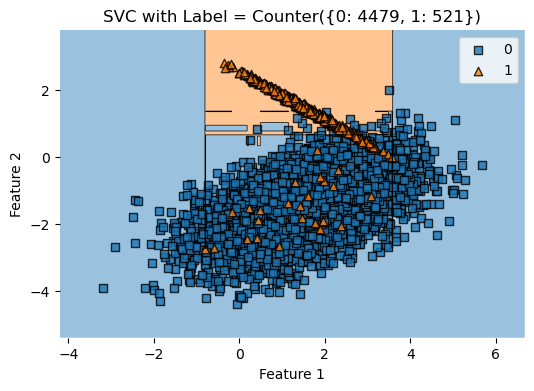

In [27]:
bdtree_fit = bdtree.fit(features, label)
plot_decision_regions(features, label, bdtree_fit)
plt.title(f'SVC with Label = {Counter(label)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.gcf().set_size_inches(6,4)

AdaBoost створив більш складний діапазон рішень. Це вже не одна пряма лінія. Статистика теж покращилася?

In [28]:
cm_bdtree=confusion_matrix(label, bdtree.predict(features))
print(cm_bdtree)
accuracy_bdtree = accuracy_score(label, bdtree.predict(features))
print(f'Accuracy: {accuracy_bdtree}')

[[4460   19]
 [  43  478]]
Accuracy: 0.9876


Згадайте результати без посилення

In [29]:
print(cm_tree_plain)
print(f'Accuracy: {accuracy_tree_plain}')

[[4442   37]
 [  47  474]]
Accuracy: 0.9832


Підвищення підвищило точність і навіть трохи покращило кількість правильно виявлених аномалій (478 проти 474). Корисно!

### Вправа №1

Ця вправа відноситься до Розділу 2 (адаптивна повторна вибірка).

Ми виявили, що недостатня вибірка дає найнижчу вартість неправильної класифікації для вказаних нами витрат. Однак ми не перевіряли, чи оптимальний наш коефіцієнт недовибірки. Чи може інше значення *resample_ratio_under* ще більше знизити нашу вартість?

Напишіть функцію для обчислення вартості неправильної класифікації для відповідного діапазону *resample_ratio_under* і знайдіть співвідношення, яке призводить до найнижчої вартості.

### Рішення №1

In [30]:
# your code


[[4388   91]
 [  27  494]]

With random undersampling the cost is: 3610
Accuracy with random undersampling is: 0.9764
resample_ratio_under is: 1.0000
[[4387   92]
 [  27  494]]

With random undersampling the cost is: 3620
Accuracy with random undersampling is: 0.9762
resample_ratio_under is: 1.1111
[[4397   82]
 [  27  494]]

With random undersampling the cost is: 3520
Accuracy with random undersampling is: 0.9782
resample_ratio_under is: 1.2222
[[4404   75]
 [  27  494]]

With random undersampling the cost is: 3450
Accuracy with random undersampling is: 0.9796
resample_ratio_under is: 1.3333
[[4409   70]
 [  28  493]]

With random undersampling the cost is: 3500
Accuracy with random undersampling is: 0.9804
resample_ratio_under is: 1.4444
[[4415   64]
 [  28  493]]

With random undersampling the cost is: 3440
Accuracy with random undersampling is: 0.9816
resample_ratio_under is: 1.5556
[[4424   55]
 [  29  492]]

With random undersampling the cost is: 3450
Accuracy with random undersa

### Вправа №2

Ця вправа відноситься до розділу 3 (AdaBoost).

Повторіть аналіз Розділу 3 зі збалансованими деревами рішень (*class_weight*=*balanced*). Чи призводить підвищення знову до покращення виявлення аномалій?

### Рішення №2

In [31]:
# your code

In [32]:
# your code

[[4412   67]
 [  23  498]]
Accuracy: 0.982


### Вправа №3

Ця вправа відноситься до Розділу 2 (адаптивна повторна вибірка).

Ми виявили, що недостатня вибірка дає найнижчу вартість неправильної класифікації для вказаних нами витрат при *resample_ratio_under = 0.3*. Доповніть вибірку, використовуючи метод SMOTE і класифікатор — SVC. 

Порівняйте вартість неправильної класифікації мотодом SMOTE   і методом ROS. 

Зробіть висновки щодо кількості неправильно класифікованих аномалій та точності (accuracy) використаних методів.

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
#  Застосовуємо SMOTE
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Створюємо аномальні зразки (30% від нормальних)
features_smote, label_smote = smote.fit_resample(features, label)

# Перевіряємо баланс після SMOTE
print("Після SMOTE:", Counter(label_smote))

Після SMOTE: Counter({0: 4479, 1: 1343})


А було для початкового датасету:

In [35]:
Counter(label)

Counter({0: 4479, 1: 521})

In [36]:
#  Тренуємо модель

# your code

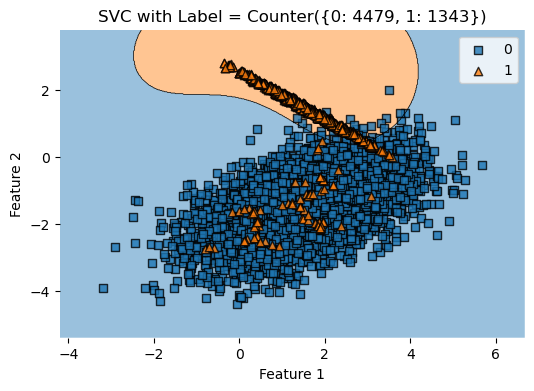

In [37]:
# your code

In [38]:
# your code

[[4444   35]
 [ 104 1239]]
Accuracy SMOTE: 0.9858


In [39]:
# your code

[[4443   36]
 [  35  486]]
Accuracy_ros: 0.9858


In [41]:
# your code

After SMOTE Oversampling
True Negative: 4444
False Positive: 35
False Negative: 104
True Positive: 1239
Accuracy: 0.9858


In [42]:
# your code

Without oversampling the cost is: 4920
With oversampling SMOTE the cost is: 10750

Accuracy without oversampling is: 0.9862
Accuracy with oversampling SMOTE is: 0.9858
